# Tarea 1: Funciones Base Radial
## Temas Selectos de Aprendizaje Máquina
### Oscar Esaú Peralta Rosales

# Resumen

Durante la realización de esta tarea, se ralizaron las siguientes actividades:

1. **Implementación de los algoritmos SGD, SGD-Momentum, NAG, ADAGRAD, ADADELTA y ADAM de forma estocástica**

  Se realizó la implementación de una función que nos permitiera obtener un muestreo del total de observaciones. 

  La función objetivo se expresa como la contribución de la suma muchos costos más pequeños, en dónde el gradiente puede ser interpretado como el valor esperado del gradiente de la muestra real.

2. **Correción del algoritmo de ADAM**

  Se detectó el error en el algoritmo de ADAM causado la actualización indebida sobre las variables que determinaban el escalamiento de la dirección y la correción del bias en la estimación del momento.

3. **Solución a una función multiobjetivo derivada de aproximar una función  a través de funciones radiales usando el algoritmo de Descenso de Gradiente**

  Sea *f* una función que puede ser expresada como suma de funciones base:

  $$
    f(x) = \sum_{j=1}^n \beta_j\phi_j(x;\Theta) + \eta(x)
  $$

  Dónde:

  - $\phi_j$ es la j-ésima función base.
  - $\Theta$ son los parámetros de la función anterior.
  - $\beta_j$ es la contribución de la j-ésima funcion base.
  - $\eta$ es el residual.

  Algunas de las funciones radiales son:

  - Kernel Gaussiano
  - Kernel Cuadrático Inverso
  - Kernel Multicuadrático
  - Kernel Multicuadrático Inverso
  - Kernel Función Tope

  Específicamente usando el Kernel Gaussiano

  $$
    \phi(x, \Theta) = \exp(-(\theta_2r)^2)
  $$
  con
  $$
    r = || x - \theta_1 ||
  $$ 

  Se buscan los parámetros $\theta_{1,j}$ y $\theta_{2,j}$ de $n$ funciones radiales $j=1,2,...,n$,  tal que minimicen el error con respecto a la función *f*, es decir:

$$
  \min_{\beta} ||\Phi\beta-Y||^2
$$

con $Y = [y_1, y_2, ..., y_m]^T$ como un conjunto de observaciones de *f* y con $\Phi = [\phi_{i,j}]$, $i=1,2,...,m$, $j=1,2,...,n$ como la matriz de coeficientes de las funciones base $\phi_{i,j} = \exp(-\theta_{2,j}||y_i - \theta_{1,j}||^2)$.




In [1]:
# @title Bibliotecas necesarias
import time

from typing import Callable, Dict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from skimage import img_as_float, data

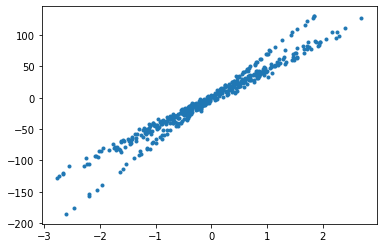

In [2]:
#@title Carga de dataset desde sklearn

n_samples = 500
X, y = datasets.make_regression(n_samples=n_samples,
                                n_features=1,
                                n_informative=2, 
                                noise=5,
                                random_state=0)

n_outliers=100
X[:n_outliers], y[:n_outliers] = datasets.make_regression(n_samples=n_outliers,
                                n_features=1,
                                n_informative=2, 
                                noise=2,
                                random_state=61)
y=np.expand_dims(y,axis=1)
plt.scatter(X[:],y[:], marker='.')

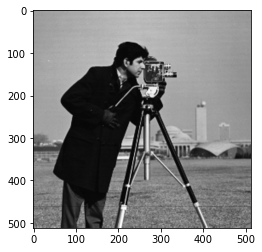

In [3]:
#@title Carga de Imagen desde sklearn
img = img_as_float(data.camera())
plt.imshow(img, cmap='gray')

# Implementación de los algoritmos SGD, SGD-Momentum, NAG, ADAGRAD, ADADELTA y ADAM de forma estocástica



In [4]:
#@title Funciones Gradiente

def grad_quadratic(theta, f_params):
    '''
    Gradiente de la funcion de costo 
           sum_i (theta@x[i]-y[i])**2
    '''    
    X = f_params['X']
    y = f_params['y']

    err=theta[0]*X+theta[1]-y
    partial0=err
    partial1=X*partial0
    gradient= np.concatenate((partial1, partial0), axis=1)
    return np.sum(gradient, axis=1)


def grad_exp(theta, f_params):
    '''
    Gradiente de la funcion de costo 
           sum_i 1-exp(-k(theta@x[i]-y[i])**2)
    '''
    kappa= f_params['kappa']
    X    = f_params['X']
    y    = f_params['y']
    err=theta[0]*X+theta[1]-y
    partial0=err*np.exp(-kappa*err**2)
    partial1=X*partial0
    gradient= np.concatenate((partial1, partial0), axis=1)
    return np.mean(gradient, axis=0)



Para la implementación de los algoritmos de forma estocástica definimos la función *get_random_sample_ids* la cual retorna una permutación de los indices de las muestras (sin repetición) en batches de tamaño *batch_size*.

In [5]:
def get_random_sample_ids(max_size: int, batch_size: int) -> np.array:
    """ Returns a numpy array with the indices for the sample to take """
    return np.random.permutation(max_size)[np.random.permutation(batch_size)]

A continuación se muestran los algoritmos modificados para el uso de las muestras originadas 

In [6]:
#@title Descenso de Gradiente Estocástico

def SGD (theta = [], grad = None, gd_params = [], f_params = []):
    '''
    Descenso Gradiente Estocástico
    
    PARÁMETROS
    ------------
    theta      : condición inicial
    grad       : función que calcula el gradiente
    
    gd_params  : lista de parámetros para el algoritmo de descenso,
                    nIter = gd_params['nIter'] número de iteraciones
                    alpha = gd_params['alpha'] tamaño de paso alpha
                    batch_size = gd_params['batch_size'] tamaño de la muestra
    
    f_params   : lista de parámetros para la función objetivo
                    kappa = f_params['kappa'] parámetro de escala (rechazo de outlies)
                    X     = f_params['X']     variable independiente
                    y     = f_params['y']     variable dependiente
    
    Regresa
    ------------
    Theta      : trayectoria de parametros
                    Theta[-1] es el valor alcanzado en la última iteración
    '''
    
    (high, dim) = f_params['X'].shape
    batch_size  = gd_params['batch_size']
    
    nIter       = gd_params['nIter']
    alpha       = gd_params['alpha']
    
    Theta = []
    
    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low = 0, high = high, size = batch_size, dtype = 'int32')
        #sample
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        
        # parámetros de la función objetivo
        smpf_params = {'kappa' : f_params['kappa'],
                       'X'     : smpX ,
                       'y'     : smpy }
        
        p = grad(theta, f_params = smpf_params)
        theta = theta - alpha*p
        Theta.append(theta)
        
    return np.array(Theta)

In [7]:
#@title Descenso de Gradiente con Momento (Inercia)

def MGD(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso de gradiente con momento (inercia)
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter = gd_params['nIter'] número de iteraciones
                      alpha = gd_params['alpha'] tamaño de paso alpha
                      eta   = gd_params['eta']  parametro de inercia (0,1]
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    (high,dim) = f_params['X'].shape
    batch_size = gd_params['batch_size']

    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p_old = np.zeros(theta.shape)
    Theta=[]
    for t in range(nIter):
        # sample 
        smpIdx = get_random_sample_ids(high, batch_size)
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}
        g = grad(theta, f_params=smpf_params)
        p = g + eta*p_old
        theta = theta - alpha*p
        p_old=p
        Theta.append(theta)
    return np.array(Theta)



In [8]:
#@title Descenso acelerado de Nesterov (NAG)

def NAG(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso acelerado de Nesterov
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter = gd_params['nIter'] número de iteraciones
                      alpha = gd_params['alpha'] tamaño de paso alpha
                      eta   = gd_params['eta']  parametro de inercia (0,1]
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''

    (high,dim) = f_params['X'].shape
    batch_size = gd_params['batch_size']

    nIter = gd_params['nIter']
    alpha = gd_params['alpha'] 
    eta   = gd_params['eta']
    p     = np.zeros(theta.shape)
    Theta=[]
    
    for t in range(nIter):
        # sample 
        smpIdx = get_random_sample_ids(high, batch_size)
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}

        pre_theta = theta - 2.0*alpha*p
        g = grad(pre_theta, f_params=smpf_params)
        p = g + eta*p
        theta = theta - alpha*p
        Theta.append(theta)
    return np.array(Theta)

In [9]:
#@title Descenso de Gradiente Adaptable (ADAGRAD)

def ADAGRAD(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso de Gradiente Adaptable (ADADELTA) 
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter    = gd_params['nIter'] número de iteraciones
                      alphaADA = gd_params['alphaADADELTA'] tamaño de paso alpha
                      eta      = gd_params['eta']  parametro adaptación del alpha
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    (high,dim) = f_params['X'].shape
    batch_size = gd_params['batch_size']

    epsilon  = 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADADELTA'] 
    eta      = gd_params['eta']
    G        = np.zeros(theta.shape)
    g        = np.zeros(theta.shape)
    p     = np.zeros(theta.shape)
    Theta=[]
    for t in range(nIter):
        # sample 
        smpIdx = get_random_sample_ids(high, batch_size)
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}

        g = grad(theta, f_params=smpf_params)
        G += g**2
        p = g + eta*p
        theta = theta - alpha / (np.sqrt(G + epsilon)) * p
        Theta.append(theta)
    return np.array(Theta)


In [10]:
#@title Descenso de Gradiente Adaptable (ADADELTA)

def ADADELTA(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso de Gradiente Adaptable (ADADELTA) 
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter    = gd_params['nIter'] número de iteraciones
                      alphaADA = gd_params['alphaADADELTA'] tamaño de paso alpha
                      eta      = gd_params['eta']  parametro adaptación del alpha
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    (high,dim) = f_params['X'].shape
    batch_size = gd_params['batch_size']

    epsilon= 1e-8
    nIter    = gd_params['nIter']
    alpha    = gd_params['alphaADADELTA'] 
    eta      = gd_params['eta']
    G        = np.zeros(theta.shape)
    g        = np.zeros(theta.shape) 
    Theta=[]
    for t in range(nIter):
        # sample 
        smpIdx = get_random_sample_ids(high, batch_size)
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        # parametros de la funcion objetivo
        smpf_params ={'kappa' : f_params['kappa'], 
                      'X'     : smpX , 
                      'y'     : smpy}

        g = grad(theta, f_params=smpf_params)
        G = eta*g**2 + (1-eta)*G
        p = 1.0/(np.sqrt(G)+epsilon)*g
        theta = theta - alpha * p
        Theta.append(theta)
    return np.array(Theta)


In [11]:
#@title Momentum Adaptable (ADAM) (Corregido)

def ADAM(theta=[], grad=None, gd_params={}, f_params={}):
    '''
    Descenso de Gradiente Adaptable con Momentum(A DAM) 
    
    Parámetros
    -----------
    theta     :   condicion inicial
    grad      :   funcion que calcula el gradiente
    gd_params :   lista de parametros para el algoritmo de descenso, 
                      nIter    = gd_params['nIter'] número de iteraciones
                      alphaADA = gd_params['alphaADAM'] tamaño de paso alpha
                      eta1     = gd_params['eta1'] factor de momentum para la direccion 
                                 de descenso (0,1)
                      eta2     = gd_params['eta2'] factor de momentum para la el 
                                 tamaño de paso (0,1)
    f_params  :   lista de parametros para la funcion objetivo, 
                      kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                      X     = f_params['X'] Variable independiente
                      y     = f_params['y'] Variable dependiente                   

    Regresa
    -----------
    Theta     :   trayectoria de los parametros
                     Theta[-1] es el valor alcanzado en la ultima iteracion
    '''
    (high, dim) = f_params['X'].shape
    batch_size  = gd_params['batch_size']
    
    epsilon = 1e-8
    nIter   = gd_params['nIter']
    alpha   = gd_params['alphaADAM'] 
    eta1    = gd_params['eta1']
    eta2    = gd_params['eta2']
    p       = np.zeros(theta.shape)
    v       = 0.0
    
    Theta   = []
    eta1_t  = eta1
    eta2_t  = eta2

    for t in range(nIter):
        # Set of sampled indices
        smpIdx = np.random.randint(low = 0, high = high, size = batch_size, dtype = 'int32')
        #sample
        smpX = f_params['X'][smpIdx]
        smpy = f_params['y'][smpIdx]
        
        # parámetros de la función objetivo
        smpf_params = { **f_params, 'kappa' : f_params['kappa'], 
                        'X'     : smpX , 
                        'y'     : smpy
                       }

        g  = grad(theta, f_params = smpf_params)
        
        p  = eta1*p + (1.0 - eta1)*g
        v  = eta2*v + (1.0 - eta2)*(g**2)

        pp = p/(1.-eta1_t) 
        vv = v/(1.-eta2_t) 
        
        theta = theta - alpha * pp / (np.sqrt(vv) + epsilon)
        Theta.append(theta)
        
        eta1_t *= eta1
        eta2_t *= eta2

    return np.array(Theta)


In [12]:
#@title Condiciones iniciales

theta=10*np.random.normal(size=2)
#theta= [-0.61752689 -0.76804482]

# parámetros del algoritmo
gd_params = {
  'alpha'          : 0.95, 
  'alphaADADELTA'  : 0.7,
  'alphaADAM'      : 0.95,
  'nIter'          : 300,
  'batch_size'     : 100,
  'eta'            : 0.9,
  'eta1'           : 0.9,
  'eta2'           : 0.999
}

# parámetros de la función objetivo
f_params={'kappa' : 0.01, 
          'X'     : X , 
          'y'     : y}

In [13]:
#@title Ejecución de los Algoritmos de Descenso de Gradiente

print("\nDescenso de Gradiente Estocástico")
ThetaSGD = SGD(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)
print('Inicio:', theta,'-> Fin:', ThetaSGD[-1,:])

print("\nDescenso de Gradiente con Momento (Inercia)")
ThetaMGD = MGD(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)
print('Inicio:', theta,'-> Fin:', ThetaMGD[-1,:])

print("\nDescenso de Gradiente Acelerado de Nesterov")
ThetaNAG = NAG(theta=theta, grad=grad_exp, 
               gd_params=gd_params, f_params=f_params)
print('Inicio:', theta,'-> Fin:', ThetaMGD[-1,:])

print("\nDescenso de Gradiente Adaptable (ADAGRAD)")
ThetaADAGRAD = ADAGRAD(theta=theta, grad=grad_exp, 
                         gd_params=gd_params, f_params=f_params)
print('Inicio:', theta,'-> Fin:', ThetaADAGRAD[-1,:])

print("\nDescenso de Gradiente Adaptable (ADADELTA)")
ThetaADADELTA = ADADELTA(theta=theta, grad=grad_exp, 
                         gd_params=gd_params, f_params=f_params)
print('Inicio:', theta,'-> Fin:', ThetaADADELTA[-1,:])

print("\nDescenso de Gradiente con Momento Adaptable (ADAM)")
ThetaADAM = ADAM(theta=theta, grad=grad_exp,
                 gd_params=gd_params, f_params=f_params)
print('Inicio:', theta,'-> Fin:', ThetaADAM[-1,:])


Descenso de Gradiente Estocástico
Inicio: [ 6.79723617 -1.01430472] -> Fin: [44.77138489 -0.2737305 ]

Descenso de Gradiente con Momento (Inercia)
Inicio: [ 6.79723617 -1.01430472] -> Fin: [45.90501494 -2.36882282]

Descenso de Gradiente Acelerado de Nesterov
Inicio: [ 6.79723617 -1.01430472] -> Fin: [45.90501494 -2.36882282]

Descenso de Gradiente Adaptable (ADAGRAD)
Inicio: [ 6.79723617 -1.01430472] -> Fin: [45.12757646 -0.23620091]

Descenso de Gradiente Adaptable (ADADELTA)
Inicio: [ 6.79723617 -1.01430472] -> Fin: [45.81374825 -0.55264325]

Descenso de Gradiente con Momento Adaptable (ADAM)
Inicio: [ 6.79723617 -1.01430472] -> Fin: [45.10813579  0.33293689]


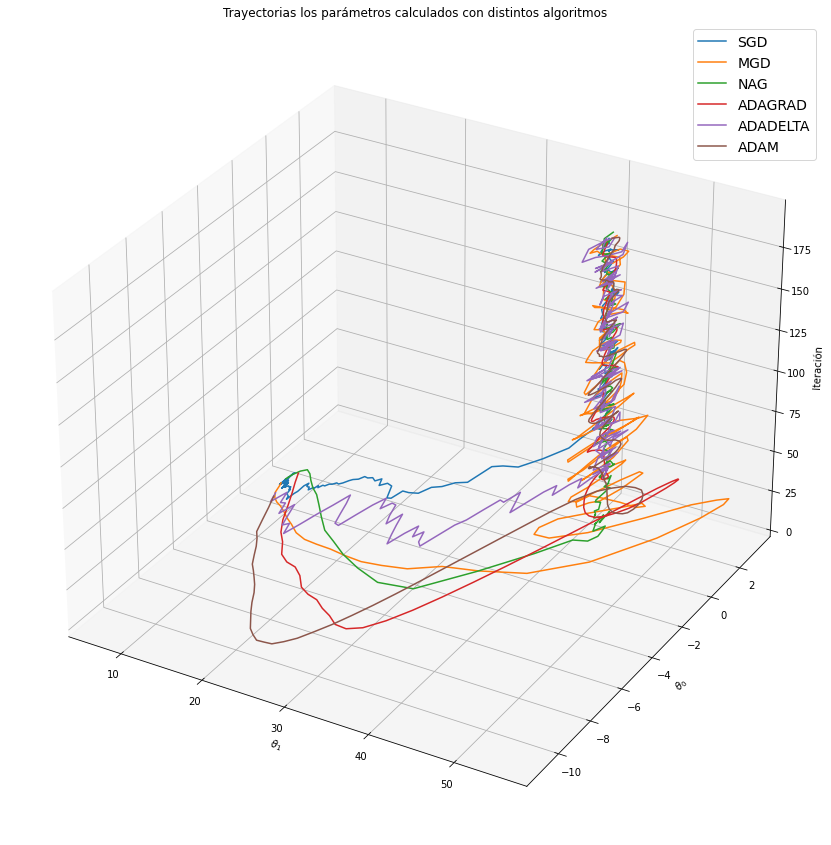

In [14]:
#@title Comparación de los distintos métodos de Descenso de Gradiente Estocásticos

mpl.rcParams['legend.fontsize'] = 14

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
nIter=np.expand_dims(np.arange(ThetaSGD.shape[0]),1) 
Tmax=200

ax.plot(ThetaSGD[:Tmax,0], ThetaSGD[:Tmax,1], nIter[:Tmax,0], label='SGD')
ax.plot(ThetaMGD[:Tmax,0], ThetaMGD[:Tmax,1], nIter[:Tmax,0], label='MGD')
ax.plot(ThetaNAG[:Tmax,0], ThetaNAG[:Tmax,1], nIter[:Tmax,0], label='NAG')
ax.plot(ThetaADAGRAD[:Tmax,0], ThetaADAGRAD[:Tmax,1], nIter[:Tmax,0], label='ADAGRAD')
ax.plot(ThetaADADELTA[:Tmax,0], ThetaADADELTA[:Tmax,1], nIter[:Tmax,0], label='ADADELTA')
ax.plot(ThetaADAM[:Tmax,0], ThetaADAM[:Tmax,1], nIter[:Tmax,0], label='ADAM')
ax.legend()
ax.set_title(r'Trayectorias los parámetros calculados con distintos algoritmos')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_0$')
ax.set_zlabel('Iteración')
plt.show()


# Solución a una función multiobjetivo derivada de aproximar una función a través de funciones radiales usando el algoritmo de Descenso de Gradiente

La solución de la ecuación

$$
  \min_{\beta} ||\Phi\beta-Y||^2
$$

está dada por 

$$
  \beta = (\Phi^T\Phi)^{-1}\Phi^TY
$$


Reescribiendo el problema, tenemos que

$$
    \min_{\beta, \mu} L(\beta, \mu; y) = \sum_i \Big[ \sum_j \beta_j \exp(-\frac{1}{2\sigma^2}(x_i - \mu_j)^2) - y_i \Big]^2
$$

en dónde tenemos que resolver para los parámetros $\Theta$ de la función base

Para ello se busca optimizar alternadamente sobre $\beta$ y $\mu$

## Algoritmo

**Inicialización**: Poner $\mu^0$ y $k=1$

**Paso 1:** Optimizar la función con respecto $\beta$ suponiendo $\mu$ fija con

$$
    \beta = (\Phi^T\Phi)^{-1}\Phi^TY
$$

**Paso 2:** Optimizar la función con respecto $\mu$ suponiendo $\beta$ fija con algún método de descenso de gradiente.

**Iterar:** hacer $k = k+1$ y repetir desde el paso uno hasta alcanzar convergencia con $||\mu^k - \mu^{k-1}|| < \epsilon$.

Al calcular y reexpresar el gradiente de la función en forma matricial obtenemos el siguiente resultado:

$$
    \nabla_\mu L = \{(\Phi\beta-Y)\beta^T\odot\Phi\} \odot \{Y1^T - 1\mu^T\}
$$



In [15]:
#@title Construcción de la matriz phi

def get_Y(img: np.array, row:int=10) -> np.array:
    """ Retorna un renglón de la imagen
        Args:
            img: Imagen de prueba
            row: Renglón requerido

        Returns:
            Renglón 'row' de la imagen
    """
    return img[row, :]

def set_mu(high:int=255, size_spc:int=10) -> np.array:
    """ Calcula mu(theta_1) equispaciado sobre Y
        Args:
            high: Valor máximo del rango
            size_spc: Tamaño del espaciado
        Returns:
            Array con los valores de espaciado
    """
    return np.linspace(0, high, size_spc)


# Y = get_Y(img)
# mu = set_mu(high=255, size_spc=num_rad_func)

# print(Y)
# print(mu)


def get_phi(Y:np.array, mu:np.array, sigma:float=20, num_rad_func:int=20) -> np.array:
    """ Construye Phi
        Args:
            Y: Array con muestras de la función a aproximar
            mu: Valores para theta_1 (posición)
            sigma: Desviación estandar
            num_rad_func: Número de funciones radiales usadas
    """
    phi = np.zeros((img.shape[1], num_rad_func))
    _sigma = 1.0 / (2*sigma**2)
    for j in range(num_rad_func):
        phi[:, j] = np.exp(- _sigma * (Y - mu[j])**2)
    return phi

# phi = get_phi(Y, mu, sigma=20, num_rad_func=20)
# print(phi[0])

In [16]:
#@title Construccion de Beta

def get_beta(Y:np.array, phi:np.array, tau=0.01, num_rad_func=20) -> np.array:
    """ Calcula y retorna los coeficientes de expación Beta
        Args:
            Y: Array con muestras de la función a aproximar
            phi: Matriz phi
            tau: Coeficiente para evitar singularidad
            n_rad_func: Número de funciones radiales usadas
        Returns:
            Coeficientes de expansión beta
    """
    return np.linalg.inv(phi.T @ phi + tau * np.identity(num_rad_func)) @ phi.T @ Y


In [17]:
#@title Función Gradiente

def grad_gaussian_radial(theta:np.array, f_params:Dict) -> np.array:
    """ Retorna el promedio del gradiente usando la función Radial Gaussiana
        ∇μL={(Φβ−Y)βT⊙Φ}⊙{Y1T−1μT}
        Args:
            theta
            f_params: Diccionario con los parámetros usados para calcular el gradiente

        Returns:
            Array gradiente
    """
    
    Y = f_params.get('y')
    beta = f_params.get('Beta')
    mu = f_params.get('mu')
    phi = f_params.get('X')
    n = f_params.get('n')
    
    # print(phi.shape, beta.shape)
    
    prod1 = (phi @ beta - Y).reshape((Y.shape[0], 1)) * beta.T
    Y = Y.reshape((Y.shape[0], 1))
    prod2 = (Y * np.ones((1, n)) - np.ones((Y.shape[0], 1)) * mu.T)
    # print(prod1.shape, prod2.shape)
    ans = prod1*prod2
    return np.mean(ans, axis=0)


In [18]:
#@title Optimization de parámetros

# Número máximo de iteraciones
max_iter =  300#@param {type: "number"}
# Desviación estandar
sigma =  20#@param {type: "number"}
# Número de funcionaes base
num_rad_func =  120#@param {type: "number"}
# Coeficiente para no singularidad
tau = 0.009  #@param {type: "number"}
# Epsilon
epsilon = 0.03 #@param {type: "number"}

theta = 10 * np.random.normal(size=2)

# parámetros del algoritmo
gd_params = {
    'alpha'          : 0.95, 
    'alphaADADELTA'  : 0.7,
    'alphaADAM'      : 0.01,
    'nIter'          : 10,
    'batch_size'     : 256,
    'eta'            : 0.9,
    'eta1'           : 0.9,
    'eta2'           : 0.999
}

# Iteración del algoritmo

# Distintos descensos de gradientes a usar
grad_algthms = [
    (SGD, 'SDG'),
    (MGD, 'MDG'), 
    (NAG, 'NAG'), 
    (ADAGRAD, 'ADAGRAD'), 
    (ADADELTA, 'ADADELTA'), 
    (ADAM, 'ADAM')
]

def optimization(algthm: Callable):
    t_init = time.clock_gettime(0)
    # Obtenemos un renglón de la imagen
    Y = get_Y(img, row=150)
    # Calculamos mu inicial
    mu = set_mu(high=255, size_spc=num_rad_func)
    # Calculamos la matriz phi inicial
    phi = get_phi(Y, mu, sigma=sigma, num_rad_func=num_rad_func)
    # Calculamos beta inicial
    beta = get_beta(Y, phi, tau=tau, num_rad_func=num_rad_func)

    # Parámetros para el gradiente
    f_params={'kappa' : 0.01, 'mu': mu, 'X': phi, 'y': Y, 'Beta': beta, 'n': num_rad_func}
    citer = 0;
    while True:
        # Optimización de beta
        beta = get_beta(Y, phi, tau=tau, num_rad_func=num_rad_func)
        # Optimización de mu
        thetas = ADAM(mu, grad=grad_gaussian_radial, gd_params=gd_params, f_params=f_params)
        mu_prev = mu
        mu = thetas[-1]
        # Obtención de la matriz phi con los nuevos beta y mu
        phi = get_phi(Y, mu, sigma=sigma, num_rad_func=num_rad_func)
        # Criterio de parada
        if np.linalg.norm(mu - mu_prev)**2 < epsilon:
            break
        # Número máximo de iteraciones si no hay converrgencia
        citer += 1
        if citer > max_iter:
            break
    t_end = time.clock_gettime(0)
    
    return Y, phi, beta, mu, t_end - t_init


# Resultados




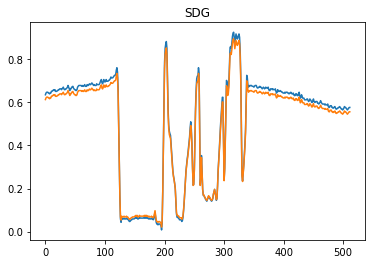

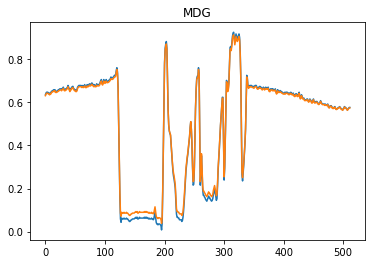

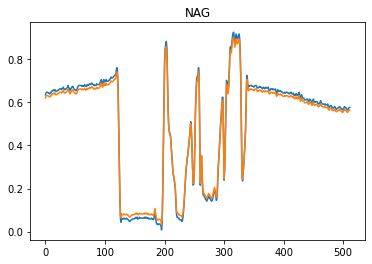

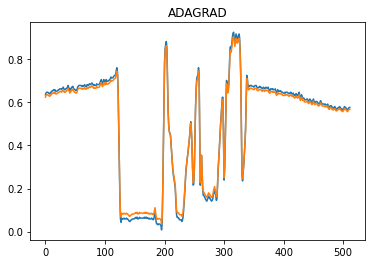

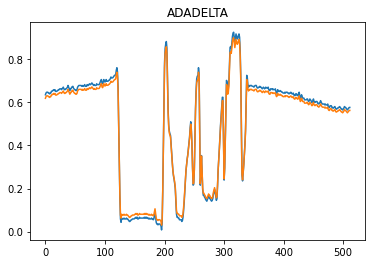

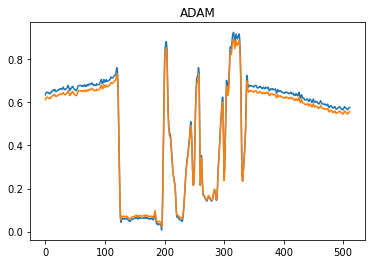

In [19]:
#@title Resultados de las aproximaciones usando los distintos algoritmos

results = [optimization(algthm[0]) for algthm in grad_algthms]
# Gráfico de aproximación

for index, (Y, phi, beta, mu, ctime) in enumerate(results):
    plt.title(grad_algthms[index][1])
    plt.plot(Y)
    plt.plot(phi.dot(beta))
    plt.show()


In [20]:
from tabulate import tabulate
times = [ 
            [algthm for (_, algthm) in grad_algthms], 
            [round(result[-1], 8) for result in results], 
            [round(np.square( result[1].dot(result[2])- result[0] ).mean(), 5) for result in results]
        ]

times[0] = ["Algorithm"] + times[0]
times[1] = ["Time"] + times[1]
times[2] = ["Cummulated Error"] + times[2]

print(tabulate(times))

----------------  ----------  ----------  ----------  ----------  ----------  ----------
Algorithm         SDG         MDG         NAG         ADAGRAD     ADADELTA    ADAM
Time              0.08008647  0.06097889  0.00984335  0.01059914  0.01094413  0.03699303
Cummulated Error  0.00039     0.00018     0.00024     0.00021     0.00027     0.0004
----------------  ----------  ----------  ----------  ----------  ----------  ----------


# Conclusiones

En general todos los algoritmos tuvieron buen resultado. Durante las pruebas se observó que el algoritmo ADAM tuvo mejores tiempos de ejecución.

Para la función radial usada (la Gaussiana) se observó que eligiendo una varianza alrededor de 20 se obtienen buenos resultados, es variable que más contribuye a la aproximación de la función original.

Para evitar que la matriz phi se hiciera singular se uso valor de $\tau = 0.009$ para realizar la contribución sobre la diagonal, con la cual se obtuvieron mejores resultados.

Además, se observó que a partir de un total de 20 funciones la similitud en la aproximación era bastante cercana, con aproximadamente 90 funciones los resultados son casi similares.

**Referencias**

- [Temas de Apredizaje Máquina](https://www.cimat.mx/~mrivera/cursos/temas_aprendizaje.html), CIMAT, 2018
- [Deep Learning](https://www.deeplearningbook.org/), Ian Goodfellow and Yoshua Bengio and Aaron Courville, 2016